# Perform initial data transformations for 5G TPM data
1. Log ratio relative to umax
1. Log ratio relative to noCu

For all of these, we'll use promoter windows of 300bp (no truncation) and we'll optionally skip operon-likely genes (2204 total)

In [1]:
import torch
# from torch.utils.data import TensorDataset,DataLoader,Dataset
# from torch import nn

import altair as alt
# import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import random
random.seed(7) #10



import utils as u
import torch_utils as tu

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#alt.data_transformers.disable_max_rows()

In [4]:
# def alter_upstream_seq_len(d,verbose=True):
#     seq_lens = [len(x) for x in d.values()]
#     max_seq_len = max(seq_lens)
#     for loc in d:
#         seq_len = len(d[loc])
#         if seq_len < max_seq_len:
#             ns = ''.join(["N" for x in range(max_seq_len-seq_len)])
#             d[loc] = ns+d[loc]
#             if verbose: 
#                 print(f"WARNING: sequence for locus {loc} is shorter ({seq_len}) than max of {max_seq_len}. Padding with Ns")
#                 print(d[loc])

# def load_data(
#         upstream_region_file,
#         op_file,
#         data_mat_file, 
#         sample2cond_file, 
#         sample_file, 
#         condition_file,
#         coded_meta_file
#         ):
#     '''
#     Wrapper function to load data from files into relavent objects
#     '''
#     # load upstream seq regions
#     seqs = u.load_promoter_seqs(upstream_region_file)
#     loc2seq = dict([(x,z) for (x,y,z) in seqs])
#     alter_upstream_seq_len(loc2seq)

    
#     # load operon estimate file
#     op_df = pd.read_csv(op_file,sep='\t')
#     op_leads = set(op_df[op_df['op?']==False]['locus_tag'].values)
    
#     # load TPM data
#     tpm_df = pd.read_csv(data_mat_file,sep='\t').fillna('')

    
#     # load mapping from sample to condition
#     with open(sample2cond_file,'r') as f:
#         sample2condition = dict(x.strip().split() for x in f.readlines())

    
#     # load sample to include file
#     if sample_file:
#         with open(sample_file,'r') as f:
#             samples = list(x.strip() for x in f.readlines())
#     # if none provided, just use all the samples from the sample2condition dict
#     else: 
#         samples = list(sample2condition.keys())

        
#     # load the conditions to include file
#     if condition_file:
#         with open(condition_file,'r') as f:
#             conditions = list(x.strip() for x in f.readlines())
#     # if none provided, just use all the conditions
#     else:
#         conditions = list(set([sample2condition[x] for x in sample2condition]))

#     # load coded metadata file
#     meta_df = pd.read_csv(coded_meta_file,sep='\t')
#     meta_df['sample'] = meta_df['#sample']+'_tpm'

#     return loc2seq, op_leads, tpm_df, sample2condition, samples, conditions, meta_df

In [5]:
#upstream_region_file = 'all_seq_info/all_loci_upstream_regions_w100_min20.fa'
upstream_region_file = 'all_proms/all_loci_upstream_regions_w300_min20.fa'
op_file = 'all_proms/loci_in_top_100perc.txt'
data_mat_file = 'data/extract_TPM_counts.tsv'
sample2cond_file = 'data/sample2condition.txt'
sample_file = None
condition_file = 'data/conditions_to_include.txt'
coded_meta_file = 'data/5G_exp_metadata_coded.tsv'

COND_COLS = ['carbon_source','oxygen_level','nitrate_level',
             'copper_level','lanthanum_level','growth_rate',
             'growth_mode']


loc2seq, op_leads, tpm_df, sample2condition, samples, conditions, meta_df = u.load_data(
    upstream_region_file,
    op_file,
    data_mat_file, 
    sample2cond_file, 
    sample_file, 
    condition_file,
    coded_meta_file
)

NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTATTTAAGAAGGTAGCGAAGAGTAAATAGATGATATTATAAAAAAATTATGCCACTATACAGCAATCAAATCAGTGCCGGCATAATTGACATAAACCGGCGTTTATTCTATCATCCCGGATCTTTTTTATCCGTTTTTGTTAACAATCATCTGAACCAGGATTTAAGGC


In [6]:
print('EQU24_RS19310' in op_leads)
print('EQU24_RS19315' in op_leads)

False
True


In [7]:
tpm_df.head()

,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,translation,gene_len,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
0,EQU24_RS00005,chromosomal replication initiator protein DnaA,CDS,dnaA,NZ_CP035467.1,0,1317,Derived by automated computational analysis us...,MSALWNNCLAKLENEISSSEFSTWIRPLQAIETDGQIKLLAPNRFV...,1318,...,38.557373,38.810668,37.444214,40.246006,40.100118,33.432274,39.880174,38.355431,30.247582,41.248441
1,EQU24_RS00010,DNA polymerase III subunit beta,CDS,,NZ_CP035467.1,1502,2603,Derived by automated computational analysis us...,MKYIINREQLLVPLQQIVSVIEKRQTMPILSNVLMVFRENTLVMTG...,1102,...,52.552767,52.461746,42.676553,49.210083,46.798476,48.142385,45.465136,46.498139,37.152951,52.902410
2,EQU24_RS00015,DNA replication/repair protein RecF,CDS,recF,NZ_CP035467.1,3060,4140,Derived by automated computational analysis us...,MSLQKLDIFNVRNIRQASLQPSPGLNLIYGANASGKSSVLEAIFIL...,1081,...,31.350991,34.914128,21.479309,24.204682,22.171104,22.006566,22.658157,22.753325,19.407103,29.834124
3,EQU24_RS00020,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,gyrB,NZ_CP035467.1,4185,6600,Derived by automated computational analysis us...,MSENIKQYDSTNIQVLKGLDAVRKRPGMYIGDTDDGTGLHHMVFEV...,2416,...,74.848501,80.850761,54.959319,64.911376,59.653059,64.648318,69.119079,65.643179,57.590223,68.306759
4,EQU24_RS00025,hypothetical protein,CDS,,NZ_CP035467.1,6825,7062,Derived by automated computational analysis us...,VKTTKYFLTTRMRPDREIIKDEWIQYVVRFPENEHIQFDGRIRRWA...,238,...,50.324948,49.349547,34.539657,36.521074,37.789611,39.358066,38.992158,35.870964,41.462392,40.227192


In [8]:
print(np.mean(tpm_df['5GB1_pA9_red_tpm']))
print(np.mean(tpm_df['5GB1C-5G-La-BR1_tpm']))

237.36055067647783
237.36055067647783


In [9]:
locus2info = u.make_info_dict(tpm_df)
locus2info['EQU24_RS19315']

{'gene': 'pmoC',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

In [10]:
df_means = u.get_gene_means_by_condition(tpm_df,samples,sample2condition)
df_means

locus_tag,exp_condition,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
0,LanzaTech,25.626702,55.711920,11.804042,76.880335,43.737438,27.940983,35.296053,25.926725,23.461781,...,7420.641716,16.014544,15.947067,16.286482,9.514666,46.013885,354.315359,157.364073,571.458102,613.084675
1,MeOH,23.323155,18.905775,18.443916,18.257805,16.950643,12.367795,43.805536,9.660950,7.292145,...,1298.247682,15.614619,20.198066,25.994364,20.950234,28.709983,93.606437,161.518124,496.980651,280.334047
2,NO3_lowO2_slow_growth,32.040358,43.646760,21.341623,62.257687,41.674925,31.911455,57.839768,16.875694,14.916147,...,6497.858109,26.263485,28.935133,23.515245,26.422667,35.157264,178.986199,164.073806,433.428735,493.885115
3,NoCu,44.338687,59.619360,28.258717,56.808319,49.829406,38.384652,81.520362,40.491969,36.566500,...,8345.775345,43.055124,34.370565,44.409579,34.591933,65.329879,253.598495,273.274694,731.042190,1087.611126
4,NoLanthanum,33.434023,43.679839,23.162675,57.287047,42.357072,41.931657,102.503601,30.216787,19.452312,...,5085.627409,16.413284,35.578138,44.613117,43.191743,21.917260,109.773330,67.267718,211.565175,328.933746
5,WT_control,34.988452,38.272163,15.495930,54.855025,35.396786,26.817623,59.558466,24.797995,27.925137,...,4939.367129,18.248719,21.027514,31.490596,45.810743,36.195898,172.298263,181.468991,403.551659,648.122601
6,WithLanthanum,35.452185,41.782237,20.634554,57.120166,34.248335,46.191637,110.711781,31.803805,19.428086,...,3942.947792,15.962203,34.308829,49.206725,39.990662,21.210809,98.090610,73.106973,194.379586,319.988959
7,aa3_KO,26.849583,45.489035,11.962099,55.846659,33.097353,28.718155,50.249664,21.490715,24.790508,...,5355.094603,16.236806,20.836285,28.298842,40.627394,30.065630,181.790564,153.928317,376.664997,657.228922
8,crotonic_acid,38.684021,52.507256,33.132559,77.849631,49.837247,37.332021,69.675355,32.001867,35.856260,...,8680.904376,42.175374,47.879804,58.961083,43.069352,81.481463,365.899345,315.553709,614.920997,676.638496
9,highCu,47.851477,79.099490,33.524043,73.320408,48.652214,33.976359,92.989818,51.940784,50.360579,...,8132.537467,48.884308,35.598730,46.099300,30.115207,89.700150,342.971435,386.483127,1021.443762,1692.391154


### Check df_means distributions

In [11]:
psuedo_count = 0.01
df_meansT = df_means.set_index("exp_condition").T + psuedo_count

df_meansT.describe()

exp_condition,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
count,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000
mean,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551,237.370551
std,3608.970762,8690.903942,3200.972660,2880.613041,3294.148756,3681.469132,3805.692304,3237.680883,3614.516314,2762.759501,3162.518375,4474.110220,2968.420641,3749.246526,7318.594948,2974.240143,3018.507121,3012.711208,5629.014009
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,15.719226,12.874708,21.188686,23.897276,28.564778,16.924923,27.018283,16.549403,25.038086,20.324120,31.321068,16.090631,21.976081,18.953623,8.962131,19.667436,18.388176,22.618816,16.357295
50%,36.887427,24.519181,45.035245,52.601061,57.446726,36.371229,55.540646,37.144976,55.721700,48.930729,66.277208,35.986272,48.932548,42.156544,18.713624,44.930841,40.188854,52.130286,33.022486
75%,85.671517,47.365154,94.104792,110.339945,114.436447,77.224832,113.447005,84.964352,116.662096,104.765223,136.511393,76.215181,105.606732,86.985434,39.979111,98.587537,89.289435,107.503077,66.810771
max,179996.873952,534996.530265,160891.758758,169237.828591,175153.392813,194488.697960,219871.115041,159144.094941,211862.680278,153361.831049,193875.490781,239995.600807,176867.906910,205534.816632,343809.711378,170727.490805,113408.855552,168221.009211,259438.757124


In [12]:
# check a quick boxplot of mean tpm data
df_meansT_melt = pd.melt(df_meansT.reset_index(), id_vars=['locus_tag'],var_name="exp_condition",value_name='tpm')
df_meansT_melt

,locus_tag,exp_condition,tpm
0,EQU24_RS00005,LanzaTech,25.636702
1,EQU24_RS00010,LanzaTech,55.721920
2,EQU24_RS00015,LanzaTech,11.814042
3,EQU24_RS00020,LanzaTech,76.890335
4,EQU24_RS00025,LanzaTech,43.747438
...,...,...,...
80042,EQU24_RS22135,unknown,31.295152
80043,EQU24_RS22140,unknown,114.118228
80044,EQU24_RS22145,unknown,119.781566
80045,EQU24_RS22150,unknown,344.152066


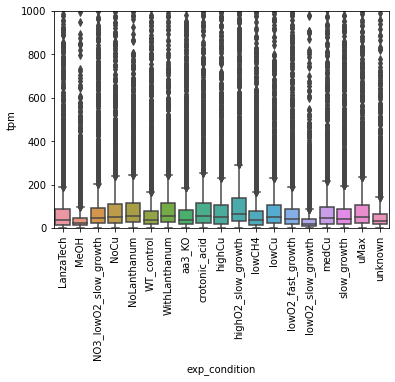

In [13]:
sns.boxplot(data=df_meansT_melt,x="exp_condition",y="tpm")
plt.ylim(-1,1000)
plt.xticks(rotation=90)
plt.show()

### Make log ratio versions of df

In [14]:
# def make_lr_df(raw_df, denom_col):
#     # initialize log ratio df from locus tags in df_meansT
#     lr_df = pd.DataFrame()
#     lr_df['locus_tag'] = raw_df.reset_index()['locus_tag']
#     lr_df = lr_df.set_index('locus_tag')
    
    
#     if denom_col not in raw_df.columns:
#         raise ValueError(f"Column {denom_col} not in dataframe. Choose from {raw_df.columns}")

#     # calculate LOG RATIO of each condition divided by denom column
#     for cond in raw_df.columns:
#         lr_df[cond] = np.log2(raw_df[cond]/raw_df[denom_col])
        
#     return lr_df

In [15]:
lr_umax = u.make_lr_df(df_meansT, 'uMax')
lr_nocu = u.make_lr_df(df_meansT, 'NoCu')

In [16]:
# spot check log calculation
df_meansT[["highCu","medCu","lowCu","NoCu","uMax"]]

exp_condition,highCu,medCu,lowCu,NoCu,uMax
locus_tag,,,,,
EQU24_RS00005,47.861477,44.920897,42.973556,44.348687,52.045884
EQU24_RS00010,79.109490,65.011074,61.209155,59.629360,59.991257
EQU24_RS00015,33.534043,29.419165,28.828713,28.268717,33.943076
EQU24_RS00020,73.330408,65.393162,61.573321,56.818319,71.052489
EQU24_RS00025,48.662214,48.729958,50.966799,49.839406,48.648085
...,...,...,...,...,...
EQU24_RS22135,89.710150,84.626668,66.743497,65.339879,89.974638
EQU24_RS22140,342.981435,340.031564,293.599291,253.608495,431.225393
EQU24_RS22145,386.493127,377.219038,313.741841,273.284694,449.945881


In [17]:
print(np.log2(47.861477/52.045884))
lr_umax[["highCu","medCu","lowCu","NoCu","uMax"]]

-0.12091915487340911


,highCu,medCu,lowCu,NoCu,uMax
locus_tag,,,,,
EQU24_RS00005,-0.120919,-0.212397,-0.276335,-0.230893,0.0
EQU24_RS00010,0.399099,0.115933,0.028995,-0.008729,0.0
EQU24_RS00015,-0.017491,-0.206361,-0.235611,-0.263911,0.0
EQU24_RS00020,0.045526,-0.119745,-0.206580,-0.322529,0.0
EQU24_RS00025,0.000419,0.002426,0.067175,0.034904,0.0
...,...,...,...,...,...
EQU24_RS22135,-0.004247,-0.088406,-0.430891,-0.461555,0.0
EQU24_RS22140,-0.330312,-0.342773,-0.554594,-0.765839,0.0
EQU24_RS22145,-0.219309,-0.254349,-0.520174,-0.719347,0.0


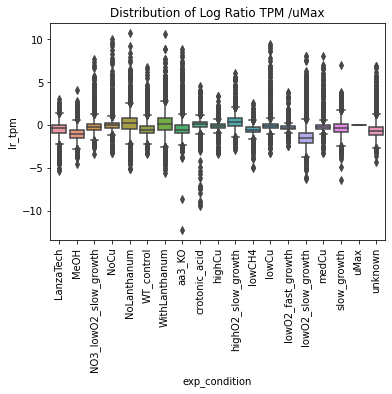

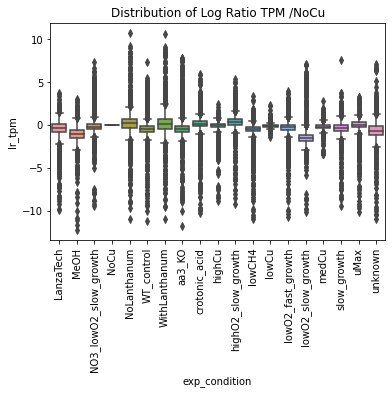

In [18]:
# check distribution of log ratio/uMax
def check_dist_of_lr_df(lr_df,name):
    lr_df_melt = pd.melt(lr_df.reset_index(), id_vars=['locus_tag'],var_name="exp_condition",value_name='lr_tpm')

    sns.boxplot(data=lr_df_melt,x="exp_condition",y="lr_tpm")
    #plt.ylim(-1,1000)
    plt.xticks(rotation=90)
    plt.title(f"Distribution of Log Ratio TPM /{name}")
    plt.show()
    
check_dist_of_lr_df(lr_umax,'uMax')
check_dist_of_lr_df(lr_nocu,'NoCu')

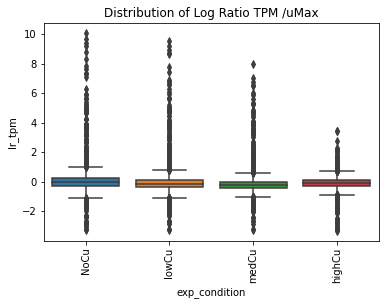

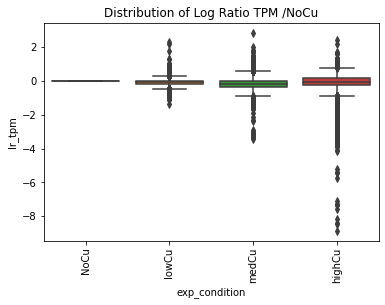

In [19]:
cu_conds = ['NoCu','lowCu','medCu','highCu']
check_dist_of_lr_df(lr_umax[cu_conds],'uMax')
check_dist_of_lr_df(lr_nocu[cu_conds],'NoCu')


## Save data frames

In [20]:
XY_umax = u.make_XY_df(lr_umax, conditions, loc2seq, op_leads)
XY_nocu = u.make_XY_df(lr_nocu, conditions, loc2seq, op_leads)

In [21]:
XY_umax

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.0,-0.542398,-0.755480,-1.157403,-0.230893,-0.212397,-0.120919,-0.276335,0.315865,-0.699444,-0.553503,-0.638036
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.0,-0.475089,-0.839191,-1.665162,-0.008729,0.115933,0.399099,0.028995,0.722720,-0.458547,-0.521517,-0.457454
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.0,-0.312854,-0.876282,-0.879190,-0.263911,-0.206361,-0.017491,-0.235611,0.402193,-0.668772,-0.717356,-0.550693
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,0.0,-0.539808,-0.620474,-1.520192,0.034904,0.002426,0.000419,0.067175,0.678171,-0.222857,-0.505928,-0.199440
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.0,0.001016,-1.077748,-1.343901,-0.002609,-0.078647,0.092409,-0.067553,-0.479305,-0.240977,0.265585,0.337004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.0,0.157759,-0.200348,-2.726296,-0.041825,-0.533827,-0.079165,-0.263448,-1.308527,-0.402906,-1.123595,-0.756444
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.0,-0.692357,-1.246394,-1.478896,-0.016197,0.013280,0.166949,-0.005485,-0.103059,-0.729110,-1.447154,-1.406975
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.0,-0.530410,-1.186861,-0.824715,-0.052273,-0.396374,0.001589,-0.320915,-0.310515,-0.969259,0.095680,-0.045678
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,0.0,-0.384774,-0.660985,-0.573066,0.150132,0.077680,-0.049750,0.032826,0.293011,-0.238399,0.359303,0.470368


In [22]:
XY_umax_noOpFilt = u.make_XY_df(lr_umax, conditions, loc2seq, op_leads, op_filt=False)
XY_nocu_noOpFilt = u.make_XY_df(lr_nocu, conditions, loc2seq, op_leads, op_filt=False)

In [23]:
XY_umax_noOpFilt

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.0,-0.542398,-0.755480,-1.157403,-0.230893,-0.212397,-0.120919,-0.276335,0.315865,-0.699444,-0.553503,-0.638036
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.0,-0.475089,-0.839191,-1.665162,-0.008729,0.115933,0.399099,0.028995,0.722720,-0.458547,-0.521517,-0.457454
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.0,-0.312854,-0.876282,-0.879190,-0.263911,-0.206361,-0.017491,-0.235611,0.402193,-0.668772,-0.717356,-0.550693
3,3,EQU24_RS00020,ATTGTTAGTTCTATGTTTAAAGCTTGCGCAAGTACAATTATTGTCG...,0.0,-0.536808,-0.725769,-1.959582,-0.322529,-0.119745,0.045526,-0.206580,0.152926,-0.190402,-0.314632,-0.310424
4,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,0.0,-0.539808,-0.620474,-1.520192,0.034904,0.002426,0.000419,0.067175,0.678171,-0.222857,-0.505928,-0.199440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,4208,EQU24_RS22135,GAAACCGTTGAATTGCGTCAAGCTCCGTTTGCCTTGTGGATGCAGG...,0.0,-0.317361,-0.575020,-1.647463,-0.461555,-0.088406,-0.004247,-0.430891,-0.790083,-1.355285,-2.084039,-2.036793
4209,4209,EQU24_RS22140,AAAGATGCACTCAATGCATCACCGGAACAATTACAAAAGTCATTGG...,0.0,-0.368451,-0.926327,-2.203608,-0.765839,-0.342773,-0.330312,-0.554594,-0.969649,-1.268513,-2.136108,-1.973783
4210,4210,EQU24_RS22145,CTTCTGAATATAAAAAAGTCTTTACCGGACCGGTAAAATCGAGTGA...,0.0,-0.257051,-0.599146,-1.477966,-0.719347,-0.254349,-0.219309,-0.520174,-0.882049,-1.455319,-2.621473,-2.741551
4211,4211,EQU24_RS22150,AAGGTAGCGAAGAGTAAATAGATGATATTATAAAAAAATTATGCCA...,0.0,-0.144392,-0.574058,-1.389524,-0.832769,-0.296682,-0.350191,-0.626172,-1.365239,-1.586915,-2.743792,-2.621573


In [26]:
# save
XY_umax.to_csv("data/XY_lr_uMax_opFilt.tsv",sep='\t')
XY_nocu.to_csv("data/XY_lr_noCu_opFilt.tsv",sep='\t')

XY_umax_noOpFilt.to_csv("data/XY_lr_uMax.tsv",sep='\t')
XY_nocu_noOpFilt.to_csv("data/XY_lr_noCu.tsv",sep='\t')